# Academy Awards Analysis 🎬
## Investigating Trends in Oscar-Winning Movies
### Author: Judd Jacobs

This project analyzes historical **Academy Award-winning films** using data from **Wikipedia**, **The Movie Database (TMDb)**, and **The Open Movie Database (OMDb)**.

## **Key Analysis Areas**
- **Best Picture trends by genre** (from Wikipedia Scrape & TMDb API) 🏆
- **Box office revenue & IMDb ratings** (OMDb API) 🎭
- **Long-term trends in Oscar-winning films** 📈

## **Step 1:** Import necessary Python Libraries 💽

In [4]:
import pandas as pd
import numpy as np
import requests
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
from urllib.parse import quote
import re
import json
from sqlalchemy import create_engine, text
from difflib import get_close_matches
import time

# # WordCloud and NLTK libraries are currently a strech goal for future development
# from wordcloud import WordCloud
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Ensure necessary NLTK components are downloaded
# nltk.download("stopwords")
# nltk.download("punkt")

## **Step 2:** Data Acquisition 🗂

### 📥 2.0: Scrape and Prepare Best Picture Data from Wikipedia

This step scrapes the [Wikipedia page for Academy Award–winning films](https://en.wikipedia.org/wiki/List_of_Academy_Award%E2%80%93winning_films) to extract and clean a table of Best Picture nominees and winners. The scraping process uses a **combined approach**:

- **`BeautifulSoup`** parses the HTML to identify which films were marked as *winners* (based on a gold background highlight in the table rows).
- **`pandas`** is used to structure and clean the tabular data.

Key features of this data ingestion and cleaning step include:

- 🏆 **Status Classification**: Each film is classified as either `"Winner"` or `"Nominee"` based on HTML styling.
- 🧹 **Data Normalization**: Column names are converted to lowercase `snake_case` for consistency and SQL compatibility.
- 🔢 **Type Conversion**: `year`, `awards`, and `nominations` columns are explicitly converted to numeric types, using nullable `Int64` where applicable.
- ✅ **Data Validation**: Built-in `assert` statements confirm that:
  - All expected columns are present.
  - The `film` and `year` values are not missing.
  - Only valid status values (`Winner`, `Nominee`) are included.
  - The `year` column is stored as an integer type.

This will produce a structured and validated DataFrame (`best_picture_wikipedia`) ready for storage in a SQLite database.

In [2]:
# 2.1: Fetch Wikipedia page and parse it with BeautifulSoup
wiki_url = "https://en.wikipedia.org/wiki/List_of_Academy_Award%E2%80%93winning_films"
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text, "html.parser")

# 2.2: Locate the table and rows
table = soup.find("table", {"class": "wikitable"})
rows = table.find_all("tr")

# 2.3: Extract column headers
headers = [th.get_text(strip=True) for th in rows[0].find_all("th")]

# 2.4: Extract table data and append 'Status' based on style
data = []
for row in rows[1:]:
    cells = row.find_all(["td", "th"])
    style = row.get("style", "")
    status = "Winner" if "background:#EEDD82" in style.replace(" ", "") else "Nominee"
    row_data = [cell.get_text(strip=True) for cell in cells]
    if row_data:
        row_data.append(status)
        data.append(row_data)

# 2.5: Append 'Status' to column headers
headers.append("Status")

# 2.6: Create initial DataFrame
best_picture_wikipedia = pd.DataFrame(data, columns=headers)

# 2.7: Normalize column names
best_picture_wikipedia.columns = (
    best_picture_wikipedia.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace(r"[^\w_]", "", regex=True)
)

# 2.8: Initial conversion of 'year' to numeric
best_picture_wikipedia['year'] = pd.to_numeric(best_picture_wikipedia['year'], errors='coerce')

# 2.9: Further clean numeric columns
for col in ['awards', 'nominations']:
    if col in best_picture_wikipedia.columns:
        best_picture_wikipedia[col] = (
            best_picture_wikipedia[col]
            .str.replace(",", "")
            .str.extract("(\\d+)")
            .astype(float)
            .astype("Int64")
        )

# 2.10: Convert year to integer (nullable)
best_picture_wikipedia['year'] = best_picture_wikipedia['year'].astype("Int64")

# 2.11: Validate data integrity
expected_columns = ['film', 'year', 'awards', 'nominations', 'status']
assert all(col in best_picture_wikipedia.columns for col in expected_columns), "Missing expected columns"
assert best_picture_wikipedia['film'].notna().all(), "Null values found in 'film'"
assert best_picture_wikipedia['year'].notna().any(), "No valid 'year' entries found"
assert set(best_picture_wikipedia['status'].unique()) <= {'Winner', 'Nominee'}, "Unexpected status values"
assert pd.api.types.is_integer_dtype(best_picture_wikipedia['year']), "'year' column is not integer"

# 2.12: Preview final cleaned DataFrame
print(best_picture_wikipedia.head())
print(best_picture_wikipedia.dtypes)


             film  year  awards  nominations   status
0           Anora  2024       5            6   Winner
1   The Brutalist  2024       3           10  Nominee
2    Emilia Pérez  2024       2           13  Nominee
3          Wicked  2024       2           10  Nominee
4  Dune: Part Two  2024       2            5  Nominee
film           object
year            Int64
awards          Int64
nominations     Int64
status         object
dtype: object


### 🗃️ Save Cleaned DataFrame to SQLite

Store the cleaned and validated `best_picture_wikipedia` DataFrame into a local SQLite database file (`academy_awards.db`) using the table name `oscars_wikipedia`.

Key features of this database integration process:

- 🧱 **Explicit Schema Definition**: The database table is created with clear column types, constraints, and a composite primary key on (`film`, `year`) to prevent duplicates.
- 🔐 **Data Integrity**: The `status` field is constrained to only accept `Winner` or `Nominee` values.
- 🔁 **Flexible Insert Mode**: The `to_sql()` method uses the `replace` mode to overwrite any existing data, ensuring the database stays synced with the cleaned DataFrame.
- ✅ **Post-insert Verification**: A row count query is executed after the insert to confirm that the operation succeeded.

This will set up the foundation for future querying, enrichment, and analysis within a structured relational database.


In [3]:
from sqlalchemy import create_engine, text
import sqlite3

# 2.13: Define the path to your database
database_path = "academy_awards.db"
table_name = "oscars_wikipedia"

# 2.14: Create engine
engine = create_engine(f"sqlite:///{database_path}")

# 2.15: Define schema with raw SQL (only if creating manually; optional step)
with engine.begin() as conn:
    conn.execute(text(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            film TEXT NOT NULL,
            year INTEGER NOT NULL,
            awards INTEGER,
            nominations INTEGER,
            status TEXT CHECK(status IN ('Winner', 'Nominee')),
            PRIMARY KEY (film, year)
        );
    """))

# 2.16: Insert data from DataFrame (will append or replace if desired)
best_picture_wikipedia.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",  # options: 'fail', 'replace', 'append'
    index=False
)

# 2.17: Confirm insertion
with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
    total_rows = result.scalar()
    print(f"✅ Successfully inserted {total_rows} rows into '{table_name}' table.")


✅ Successfully inserted 1387 rows into 'oscars_wikipedia' table.


### 🎭 Fetch & Normalize Movie Genres from TMDb API

This cell enriches the Wikipedia-based Best Picture dataset by using **The Movie Database (TMDb) API** to retrieve detailed **genre information** for each film. It improves match accuracy, ensures data integrity, and produces a clean long-format DataFrame that is suitable for further analysis and storage.

**Key steps and improvements:**

- 🔍 **Fuzzy Matching Support**: If TMDb does not return an exact match for a film title, the function tries to find a close match using `difflib.get_close_matches()`.
- 🧭 **Year Disambiguation**: Each search includes the film's release year to better filter results.
- ⏱️ **Rate Limiting**: A 250ms pause between requests ensures compliance with TMDb's API rate limits.
- 🧹 **Genre Normalization**: Each genre is flattened into its own row (one movie → many genres).
- 🛑 **Error Logging**: Titles with no valid match are skipped and logged separately for future review.
- ✅ **De-duplication**: The final genre list is cleaned of redundant rows using `.drop_duplicates()`.

This output will be useful for identifying genre trends across decades, constructing visualizations, and enriching the SQLite database.


In [34]:
# Load environment variables from .env file
load_dotenv()

# Access the TMDB API keys stored in the .env file
tmdb_api_key = os.getenv('TMDB_API_KEY')
tmdb_api_read_access_token = os.getenv('TMDB_API_READ_ACCESS_TOKEN')

tmdb_api_base_url = "https://api.themoviedb.org/3"

# Function to get genre mappings (ID -> Name)
def get_genre_mapping() -> dict:
    url = f"{tmdb_api_base_url}/genre/movie/list?language=en-US"
    headers = {"accept": "application/json", "Authorization": f"Bearer {tmdb_api_read_access_token}"}

    response = requests.get(url, headers=headers)
    data = response.json()

    if "genres" in data:
        return {genre["id"]: genre["name"] for genre in data["genres"]}
    return {}

# Function to query TMDB API and get genre names for movies
def get_movie_genres(films_df) -> pd.DataFrame:
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {tmdb_api_read_access_token}"
    }

    genre_mapping = get_genre_mapping()
    genre_rows = []
    errors = []

    for _, row in films_df.iterrows():
        title = row['film']
        year = row['year']
        encoded_title = quote(title)

        url = f"{tmdb_api_base_url}/search/movie?query={encoded_title}&include_adult=false&language=en-US&page=1&primary_release_year={year}"
        response = requests.get(url, headers=headers)
        data = response.json()

        # Rate limiting
        time.sleep(0.25)

        genres = []
        match_title = None

        if "results" in data and data["results"]:
            exact_match = next((movie for movie in data["results"] if movie["title"].lower().strip() == title.lower().strip()), None)

            if not exact_match:
                # Try fuzzy matching if no exact match found
                titles = [movie["title"] for movie in data["results"]]
                close_matches = get_close_matches(title, titles, n=1, cutoff=0.8)
                if close_matches:
                    match_title = close_matches[0]
                    exact_match = next((movie for movie in data["results"] if movie["title"] == match_title), None)

            if exact_match:
                genre_ids = exact_match.get("genre_ids", [])
                genres = [genre_mapping.get(gid, "Unknown Genre") for gid in genre_ids]

        if not genres:
            errors.append({"film": title, "year": year})
            continue

        for genre in genres:
            genre_rows.append({"film": title, "year": year, "genre": genre})

    genre_df = pd.DataFrame(genre_rows).drop_duplicates()
    return genre_df

# Generate genre dataframe using film titles and years
tmdb_genre_results = get_movie_genres(best_picture_wikipedia[["film", "year"]])

# Ensure proper data types
tmdb_genre_results['year'] = pd.to_numeric(tmdb_genre_results['year'], errors='coerce').astype('Int64')

# Display sample and data types
print(tmdb_genre_results.head())
print(tmdb_genre_results.dtypes)


            film  year    genre
0          Anora  2024    Drama
1          Anora  2024   Comedy
2          Anora  2024  Romance
3  The Brutalist  2024    Drama
4   Emilia Pérez  2024    Drama
film     object
year      Int64
genre    object
dtype: object


### 🗃️ Save TMDb Genre Data to SQLite Database

This cell saves the normalized genre data (`tmdb_genre_results`) into the SQLite database (`academy_awards.db`) using a new table called `movie_genres`. Each row in this table represents a single genre assigned to a film for a given year.

Key features of this database export step:

- ✅ Saves data in long format for clean relational use
- 🧩 Table includes `film`, `year`, and `genre` columns
- 🔐 Primary key constraint ensures uniqueness by film, year, and genre
- ♻️ Existing table (if present) will be replaced with fresh data


In [35]:
# Define database path and table name
database_path = "academy_awards.db"
table_name = "movie_genres"

# Create engine for database connection
engine = create_engine(f"sqlite:///{database_path}")

# Define schema and create table if not exists
with engine.begin() as conn:
    conn.execute(text(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            film TEXT NOT NULL,
            year INTEGER NOT NULL,
            genre TEXT NOT NULL,
            PRIMARY KEY (film, year, genre)
        );
    """))

# Write data to SQLite (replace if exists)
tmdb_genre_results.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",
    index=False
)

# Confirm insertion
with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
    total_rows = result.scalar()
    print(f"✅ Successfully inserted {total_rows} rows into '{table_name}' table.")


✅ Successfully inserted 2731 rows into 'movie_genres' table.


### 🎬 Fetch Movie Metadata from OMDb API

This cell uses the **OMDb API** to enrich the Best Picture dataset with additional movie metadata such as:

- 💰 Box office revenue
- ⏱️ Runtime
- ⭐ IMDb rating and Metascore
- 📝 Plot summary
- 🌐 Language and Country

Each record is matched using the film title and year. To improve performance and avoid redundant API calls, results are **cached locally in a `.json` file**. On subsequent runs, only uncached titles will be queried from the API.


In [ ]:
# Load OMDb API key from environment
omdb_api_key = os.getenv("OMDB_API_KEY")

# Base URL for OMDb API
omdb_api_url = "http://www.omdbapi.com/"

# Load existing cache if available
import os.path
cache_file = "omdb_cache.json"
if os.path.exists(cache_file):
    omdb_cache = pd.read_json(cache_file)
else:
    omdb_cache = pd.DataFrame()

# Function to fetch metadata for a list of films
def get_omdb_metadata(films, existing_cache) -> pd.DataFrame:
    records = []
    errors = []
    seen_keys = set(zip(existing_cache['film'], existing_cache['year'])) if not existing_cache.empty else set()

    for _, row in films.iterrows():
        title = row['film']
        year = row['year']

        if (title, year) in seen_keys:
            continue  # skip already cached

        params = {
            "t": title,
            "y": year,
            "apikey": omdb_api_key
        }

        response = requests.get(omdb_api_url, params=params)
        print(f"URL: {response.url} | Status: {response.status_code} | Text: {response.text[:200]}")
        try:
            data = response.json()
        except Exception as e:
            print(f"⚠️ Failed to parse JSON for: {title} ({year}) — {e}")
            errors.append({"film": title, "year": year, "error": "Invalid JSON"})
            continue

        if data.get("Response") == "True":
            records.append({
                "film": title,
                "year": year,
                "title_api": data.get("Title"),
                "rated": data.get("Rated"),
                "released": data.get("Released"),
                "runtime": data.get("Runtime"),
                "genre": data.get("Genre"),
                "director": data.get("Director"),
                "writer": data.get("Writer"),
                "actors": data.get("Actors"),
                "plot": data.get("Plot"),
                "language": data.get("Language"),
                "country": data.get("Country"),
                "awards": data.get("Awards"),
                "poster": data.get("Poster"),
                "ratings": data.get("Ratings"),
                "metascore": data.get("Metascore"),
                "imdbRating": data.get("imdbRating"),
                "imdbVotes": data.get("imdbVotes"),
                "imdbID": data.get("imdbID"),
                "type": data.get("Type"),
                "boxOffice": data.get("BoxOffice"),
                "response": data.get("Response")
            })
        else:
            errors.append({"film": title, "year": year, "error": data.get("Error")})

    return pd.DataFrame(records), pd.DataFrame(errors)

# Run the metadata fetch, combining with cache
new_records, omdb_errors = get_omdb_metadata(best_picture_wikipedia[["film", "year"]], omdb_cache)
omdb_metadata = pd.concat([omdb_cache, new_records], ignore_index=True).drop_duplicates(subset=["film", "year"])

# Save updated cache
omdb_metadata.to_json(cache_file, orient="records", indent=2)

# Preview the results
print(omdb_metadata.head())

# Convert and clean data types for key fields
omdb_metadata['runtime_mins'] = omdb_metadata['runtime'].str.extract(r'(\d+)').astype('Int64')

omdb_metadata['boxOffice_clean'] = pd.to_numeric(
    omdb_metadata['boxOffice']
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "")
    .replace(["N/A", "nan"], pd.NA),
    errors='coerce'
)

omdb_metadata['metascore'] = pd.to_numeric(omdb_metadata['metascore'], errors='coerce')
omdb_metadata['imdbRating'] = pd.to_numeric(omdb_metadata['imdbRating'], errors='coerce')

omdb_metadata['imdbVotes'] = (
    omdb_metadata['imdbVotes']
    .str.replace(",", "")
    .replace("N/A", pd.NA)
    .astype('Int64')
)

print(omdb_metadata.dtypes)

# Summary of unmatched or errored entries
if not omdb_errors.empty:
    print(f"\n⚠️ {len(omdb_errors)} movies could not be matched or returned errors.")
    print(omdb_errors.sort_values(by="year", ascending=False).reset_index(drop=True))
else:
    print("\n✅ All movies successfully matched in OMDb.")


URL: http://www.omdbapi.com/?t=I%27m+Not+a+Robot&y=2024&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=In+the+Shadow+of+the+Cypress&y=2024&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=The+Only+Girl+in+the+Orchestra&y=2024&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=War+Is+Over%21+Inspired+by+the+Music+of+John+and+Yoko&y=2023&apikey=a0257149 | Status: 200 | Text: {"Response":"False","Error":"Movie not found!"}
URL: http://www.omdbapi.com/?t=Nomadland&y=%3CNA%3E&apikey=a0257149 | Status: 500 | Text: <!DOCTYPE html>
<html>
    <head>
        <title>A potentially dangerous Request.QueryString value was detected from the client (y=&quot;&lt;NA&gt;&quot;).</title>
        <meta name="viewport" co
⚠️ Failed to parse JSON for: Nomadland (<NA>) — Expecting value: line 1 column 1 (cha

In [20]:
omdb_errors.sort_values(by="year", ascending=False).reset_index(drop=True)
omdb_errors

,film,year,error
0,I'm Not a Robot,2024,Movie not found!
1,In the Shadow of the Cypress,2024,Movie not found!
2,The Only Girl in the Orchestra,2024,Movie not found!
3,War Is Over! Inspired by the Music of John and...,2023,Movie not found!
4,Nomadland,<NA>,Invalid JSON
...,...,...,...
242,With Byrd at the South Pole,<NA>,Invalid JSON
243,World Without Sun(Le Monde sans soleil),1964,Movie not found!
244,Wrestling Swordfish,<NA>,Invalid JSON
245,"Yesterday, Today and Tomorrow(Ieri, oggi, domani)",1964,Movie not found!


### 🗃️ Save OMDb Metadata to SQLite Database

This cell saves the cleaned and enriched OMDb metadata stored in the `omdb_metadata` DataFrame to a SQLite database (`academy_awards.db`).

Key features of this step:
- Stores full movie metadata from the OMDb API
- Uses a structured schema with a composite primary key on (`film`, `year`)
- Automatically replaces existing data in the table `omdb_metadata` for easy refresh


In [22]:
# Define database path and table name
database_path = "academy_awards.db"
table_name = "omdb_metadata"
engine = create_engine(f"sqlite:///{database_path}")

# Define table schema and create if not exists
with engine.begin() as conn:
    conn.execute(text(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            film TEXT NOT NULL,
            year INTEGER NOT NULL,
            title_api TEXT,
            rated TEXT,
            released TEXT,
            runtime TEXT,
            genre TEXT,
            director TEXT,
            writer TEXT,
            actors TEXT,
            plot TEXT,
            language TEXT,
            country TEXT,
            awards TEXT,
            poster TEXT,
            ratings TEXT,
            metascore REAL,
            imdbRating REAL,
            imdbVotes INTEGER,
            imdbID TEXT,
            type TEXT,
            boxOffice TEXT,
            response TEXT,
            runtime_mins INTEGER,
            boxOffice_clean REAL,
            PRIMARY KEY (film, year)
        );
    """))

# Convert lists to strings for SQLite compatibility
omdb_metadata["ratings"] = omdb_metadata["ratings"].astype(str)

# Write data to SQLite (replace if exists)
table_inserted = omdb_metadata.to_sql(
    name=table_name,
    con=engine,
    if_exists="replace",
    index=False
)

# Confirm insertion
with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name}"))
    row_count = result.scalar()
    print(f"✅ Successfully inserted {row_count} rows into '{table_name}' table.")


✅ Successfully inserted 1140 rows into 'omdb_metadata' table.


Continue here

In [ ]:
# Confirm column names for both DataFrames
print("best_picture_wikipedia columns:", best_picture_wikipedia.columns.tolist())
print("tmdb_genre_results columns:", tmdb_genre_results.columns.tolist())

In [ ]:
# Merge best_picture_wikipedia and tmdb_genre_results DataFrames on "Film"/"Title"
best_picture_merged = best_picture_wikipedia.merge(
    tmdb_genre_results,
    left_on="Film",
    right_on="Title",
    how="left"
)

# Drop the now redundant "Title" column
best_picture_merged.drop("Title", axis=1, inplace=True)

# Split the genres into separate columns
best_picture_merged = best_picture_merged.explode("Genres")
best_picture_merged = pd.concat([best_picture_merged, best_picture_merged["Genres"].str.get_dummies()], axis=1)

# Print the updated DataFrame
print(best_picture_merged.head())
print(best_picture_merged.columns)

## Exploratory Data Analysis


### 📊 Explore IMDb Ratings Distribution of Best Picture Nominees and Winners

This visualization shows the distribution of IMDb ratings for all Best Picture nominees and winners, assessing how critically acclaimed these films are on average and whether there's a notable cluster of higher-rated titles.


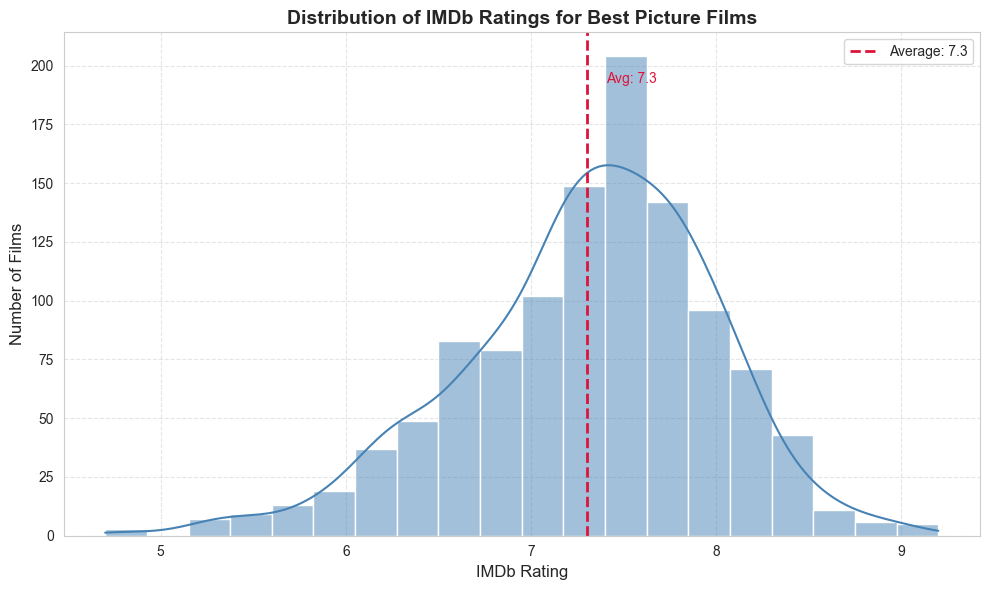

In [50]:
# Filter valid IMDb ratings
ratings_data = omdb_metadata["imdbRating"].dropna()

# Calculate average rating
avg_rating = ratings_data.mean()

# Create histogram with KDE overlay
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.histplot(ratings_data, bins=20, kde=True, color="#4682B4", edgecolor="white")

# Add vertical line for average rating
plt.axvline(avg_rating, color="crimson", linestyle="--", linewidth=2, label=f"Average: {avg_rating:.1f}")
plt.text(avg_rating + 0.1, plt.ylim()[1] * 0.9, f"Avg: {avg_rating:.1f}", color="crimson", fontsize=10)

# Titles and labels
plt.title("Distribution of IMDb Ratings for Best Picture Films", fontsize=14, fontweight='bold')
plt.xlabel("IMDb Rating", fontsize=12)
plt.ylabel("Number of Films", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 📝 Summary of Results

The histogram reveals a fairly symmetrical distribution of IMDb ratings among Best Picture nominees and winners. Most films cluster between **6.5 and 8.0**, with a notable peak around the **7.3 average rating**.

There are very few films rated below 6.0 or above 8.5, suggesting that Best Picture films are generally well-received but rarely achieve extreme highs or lows in viewer scores. This consistency highlights a solid baseline of critical and audience acclaim.


### 📊 Average IMDb Ratings by Decade for Best Picture Nominees and Winners

This visualization explores how the average IMDb rating of Best Picture nominees and winners has evolved across different decades. It offers insight into whether audience reception has improved, declined, or remained consistent over time.


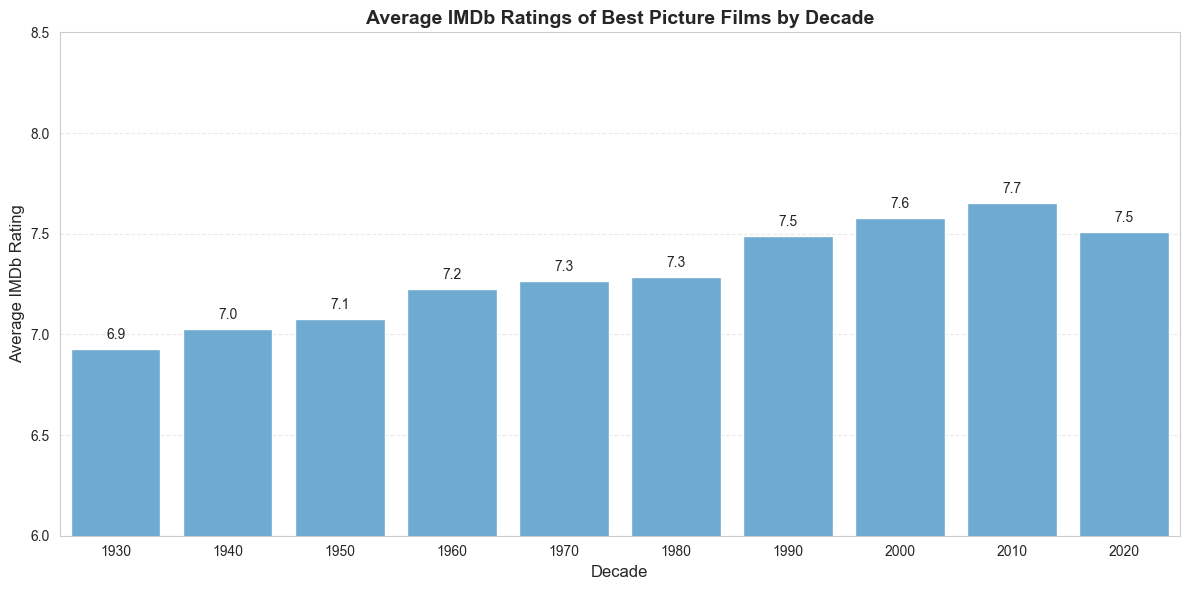

In [51]:
# Create a "decade" column
omdb_metadata["decade"] = (omdb_metadata["year"] // 10) * 10

# Group by decade and calculate average rating
decade_ratings = omdb_metadata.groupby("decade")["imdbRating"].mean().reset_index()

# Create the barplot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(data=decade_ratings, x="decade", y="imdbRating", color="#5DADE2")

# Annotate each bar with rating
for index, row in decade_ratings.iterrows():
    plt.text(x=index, y=row["imdbRating"] + 0.05, s=f"{row['imdbRating']:.1f}", ha='center', fontsize=10)

# Titles and labels
plt.title("Average IMDb Ratings of Best Picture Films by Decade", fontsize=14, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average IMDb Rating", fontsize=12)
plt.ylim(6, 8.5)
plt.grid(axis='y', linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### 📝 Summary of Results

This bar chart highlights a gradual increase in IMDb ratings for Best Picture nominees and winners from the 1930s to the 2010s. Starting with a rating of **6.9** in the 1930s, average ratings rose steadily each decade, peaking in the **2010s** at **7.7**. The **2020s** show a slight dip to **7.5**, though it's still among the highest.

These results suggest that audience sentiment toward Oscar-nominated and winning films has become more favorable over time, with more recent decades enjoying consistently strong ratings.


### 📊 Average IMDb Ratings by Genre

This visualization explores the relationship between film **genres** and their **average IMDb ratings** across all Best Picture nominees and winners. By aggregating genre-level scores, we can identify trends such as which genres tend to be more critically acclaimed, and which may perform lower on average.

We merge genre data from TMDb (`tmdb_genre_results`) with IMDb ratings from OMDb (`omdb_metadata`) to compute average ratings per genre. The output is a horizontal bar chart ranking genres by their average rating, offering a fun and insightful look at genre-based patterns in award-winning films.


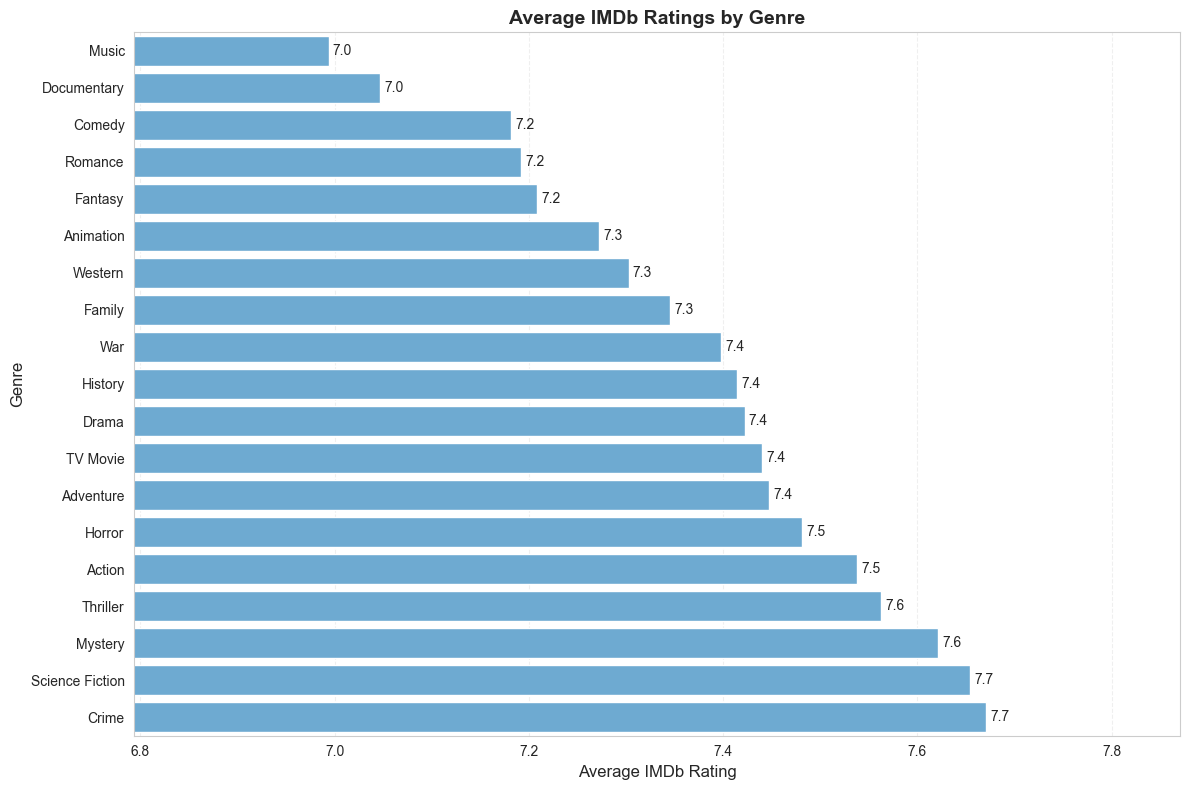

In [52]:
# Drop potential duplicate 'genre' column in omdb_metadata
omdb_metadata_clean = omdb_metadata.drop(columns=["genre"], errors="ignore")

# Merge genre data with IMDb ratings
genre_data = tmdb_genre_results.merge(omdb_metadata_clean, on=["film", "year"])

# Flatten the 'genre' column if it contains lists
genre_data = genre_data.explode("genre")

# Calculate average rating per genre
genre_summary = (
    genre_data.groupby("genre")["imdbRating"]
    .mean()
    .reset_index()
    .sort_values(by="imdbRating", ascending=True)
)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=genre_summary,
    x="imdbRating",
    y="genre",
    color="#5DADE2"
)

# Annotate bars with rating values directly using container heights
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

plt.title("Average IMDb Ratings by Genre", fontsize=14, fontweight="bold")
plt.xlabel("Average IMDb Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.xlim(genre_summary["imdbRating"].min() - 0.2, genre_summary["imdbRating"].max() + 0.2)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### 📝 Summary of Results

This visualization reveals that **Crime**, **Science Fiction**, and **Mystery** films have the **highest average IMDb ratings**, each scoring **7.6 or above**, suggesting these genres are consistently well-regarded among Best Picture nominees and winners. Close behind are **Thriller**, **Action**, and **Adventure** films, all performing strongly.

In contrast, genres like **Music** and **Documentary** have the **lowest average ratings**, falling below **7.0**, indicating that while they may be nominated, they tend to receive more mixed audience or critical reception.

The spread across genres is relatively tight—most average ratings cluster between **7.2 and 7.6**—but this breakdown still offers useful insight into which genres tend to be more critically favored in Oscar-recognized films.


### 📊 Average IMDb Ratings by Decade

This visualization examines how the **average IMDb ratings** of Best Picture nominees and winners have evolved over time by **decade**. By grouping films into ten-year intervals, we can explore whether critical acclaim has shifted across eras of filmmaking and identify any generational trends in award-winning cinema.

We begin by creating a `decade` column from each film's release year, group by that column, and then calculate the mean IMDb rating per decade. The final output is a bar chart that visually compares the average scores of different cinematic eras.

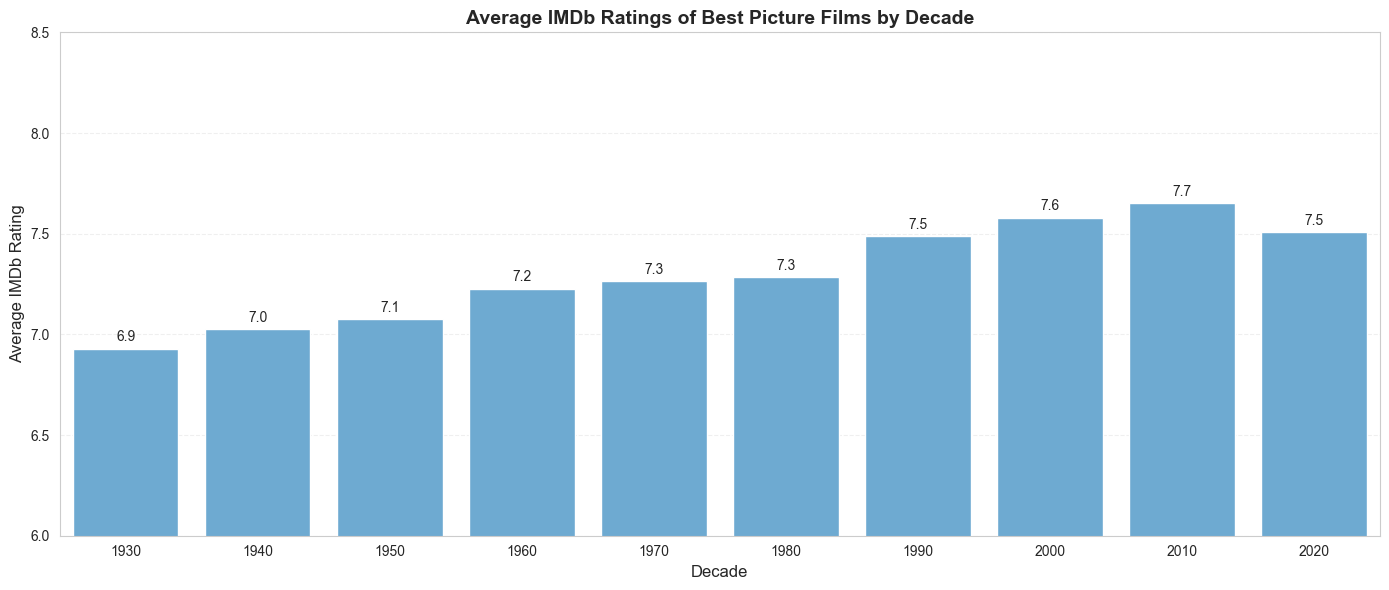

In [53]:
# Create a 'decade' column
omdb_metadata_clean = omdb_metadata.dropna(subset=["year", "imdbRating"])
omdb_metadata_clean = omdb_metadata_clean.copy()
omdb_metadata_clean["decade"] = (omdb_metadata_clean["year"] // 10) * 10

# Group by decade and calculate average IMDb rating
decade_summary = (
    omdb_metadata_clean.groupby("decade")["imdbRating"]
    .mean()
    .reset_index()
    .sort_values("decade")
)

# Plot the bar chart
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=decade_summary, x="decade", y="imdbRating", color="#5DADE2")

# Annotate bars with values
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

plt.title("Average IMDb Ratings of Best Picture Films by Decade", fontsize=14, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average IMDb Rating", fontsize=12)
plt.ylim(6.0, 8.5)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


### 📝 Summary of Results

The bar chart demonstrates a **gradual rise** in average IMDb ratings for Best Picture films over the decades, with a notable **peak in the 2010s**, reaching an average score of **7.7**. This suggests recent films recognized by the Academy tend to receive higher audience or critical approval.

Earlier decades like the **1930s and 1940s** show **lower average ratings**, around **6.9–7.1**, which may reflect evolving storytelling styles, pacing, or film quality standards over time. From the **1960s onward**, the scores steadily climb, plateauing slightly in the 2000s and 2020s.

Overall, this trend suggests a positive trajectory in critical perception of Oscar-nominated and winning films over time, possibly reflecting improvements in filmmaking technology, diversity in narratives, or shifting cultural tastes.


### 📊 Top 10 Highest-Grossing Best Picture Nominees and Winners

This visualization highlights the **Top 10 highest-grossing films** among Best Picture nominees and winners, based on their box office revenue. It helps us identify the most commercially successful Oscar contenders, offering a fun perspective for moviegoers who love big hits and blockbusters.

To ensure accuracy, the chart uses the cleaned `boxOffice_clean` values from the OMDb API data and sorts the data to find the top 10 earners. Titles are displayed clearly to show which award-winning films captured the most ticket sales.

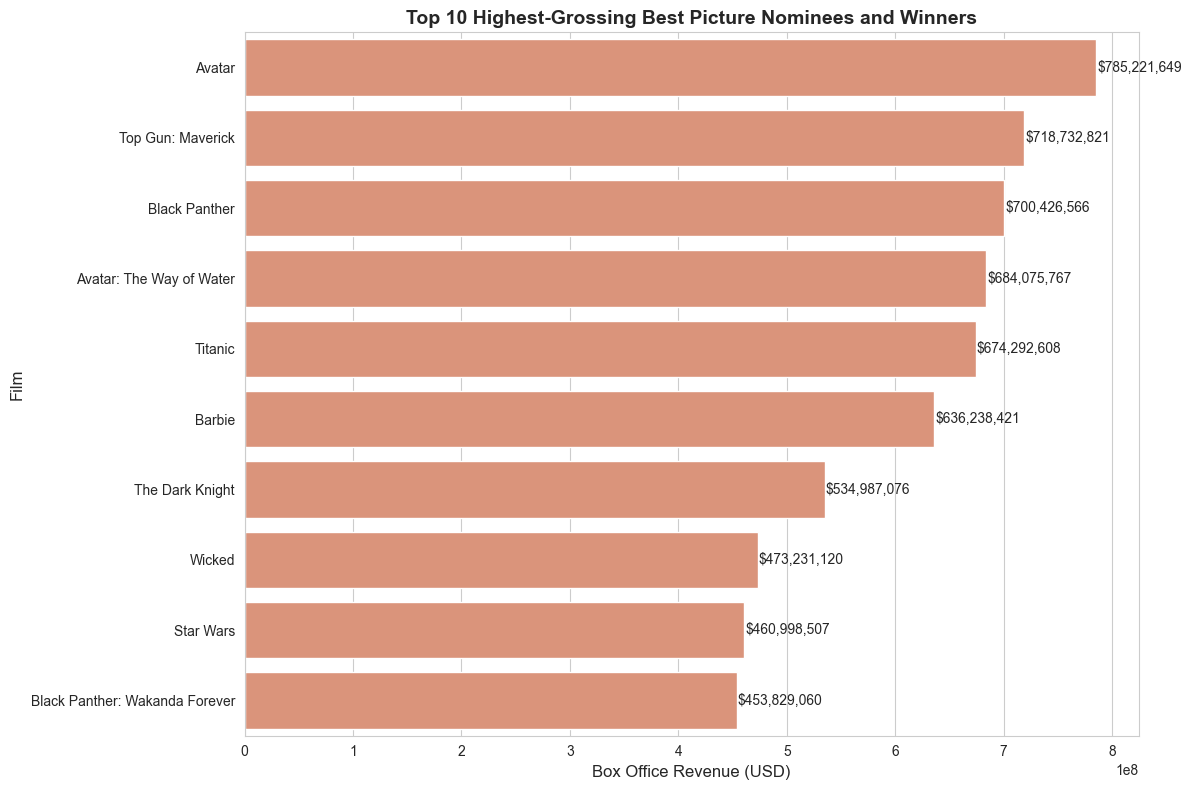

In [57]:
# Select Top 10 Highest-Grossing Films
highest_grossing = (
    omdb_metadata_clean.dropna(subset=["boxOffice_clean"])
    .sort_values(by="boxOffice_clean", ascending=False)
    .head(10)
)

# Append 👑 to winners
highest_grossing = highest_grossing.copy()
highest_grossing["label"] = highest_grossing.apply(
    lambda row: f"{row['film']} 👑" if row.get("winner") == True else row['film'], axis=1
)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=highest_grossing,
    y="label",
    x="boxOffice_clean"
)

# Add labels to bars
for index, value in enumerate(highest_grossing["boxOffice_clean"]):
    ax.text(
        value + 1e6,
        index,
        f"${value:,.0f}",
        va="center",
        fontsize=10
    )

plt.title("Top 10 Highest-Grossing Best Picture Nominees and Winners", fontsize=14, fontweight="bold")
plt.xlabel("Box Office Revenue (USD)", fontsize=12)
plt.ylabel("Film", fontsize=12)
plt.tight_layout()
plt.show()


### 📝 Summary of Results

This bar chart reveals the **Top 10 box office giants** among Oscar-nominated or winning films. These titles earned the most money at the box office, showcasing their popularity with general audiences.

While the Academy often honors critical excellence, these films also achieved major commercial success—blending prestige with mass appeal. It's a great reminder that sometimes, Oscar-worthy films can also be crowd-pleasers and box office blockbusters.


## START HERE


In [ ]:
# # Box Office Revenue vs Number of Nominations
# box_office_vs_nomination = movies.dropna(subset=["BoxOffice", "Nominations"])

# plt.figure(figsize=(10, 6))
# plt.scatter(box_office_vs_nomination["Nominations"], box_office_vs_nomination["BoxOffice"], alpha=0.6)
# plt.title("Box Office Revenue vs Number of Nominations")
# plt.xlabel("Number of Nominations")
# plt.ylabel("Box Office Revenue (USD)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()
